# Prostate Imaging Test - Classification

## Imports

In [117]:
import nibabel as nb
import dicom2nifti
from skimage.transform import resize
import shutil
from sklearn.model_selection import train_test_split

import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

## Data Exploration & Pre-processing

### Explore training images

In [10]:
tr1 = nb.load('Dataset002_Prostate/lesions/images/T2/ProstateX-0001_t2_tse_tra_10.nii.gz')
print(tr1)


<class 'nibabel.nifti1.Nifti1Image'>
data shape (384, 384, 19)
affine:
[[-5.00000000e-01  1.02551703e-10  5.20416910e-17  1.18955307e+02]
 [ 1.01932400e-10  4.96980488e-01 -3.29202890e-01 -1.24503738e+02]
 [ 1.12534504e-11  5.48671596e-02  2.98188233e+00 -5.43799973e+01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
metadata:
<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : np.bytes_(b'')
db_name         : np.bytes_(b'')
extents         : 0
session_error   : 0
regular         : np.bytes_(b'r')
dim_info        : 54
dim             : [  3 384 384  19   1   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : int16
bitpix          : 16
slice_start     : 0
pixdim          : [-1.    0.5   0.5   3.    5.66  0.    0.    0.  ]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 10
ca

In [11]:
tr1_fdata = tr1.get_fdata()
print(tr1_fdata.dtype, tr1_fdata.shape)

float64 (384, 384, 19)


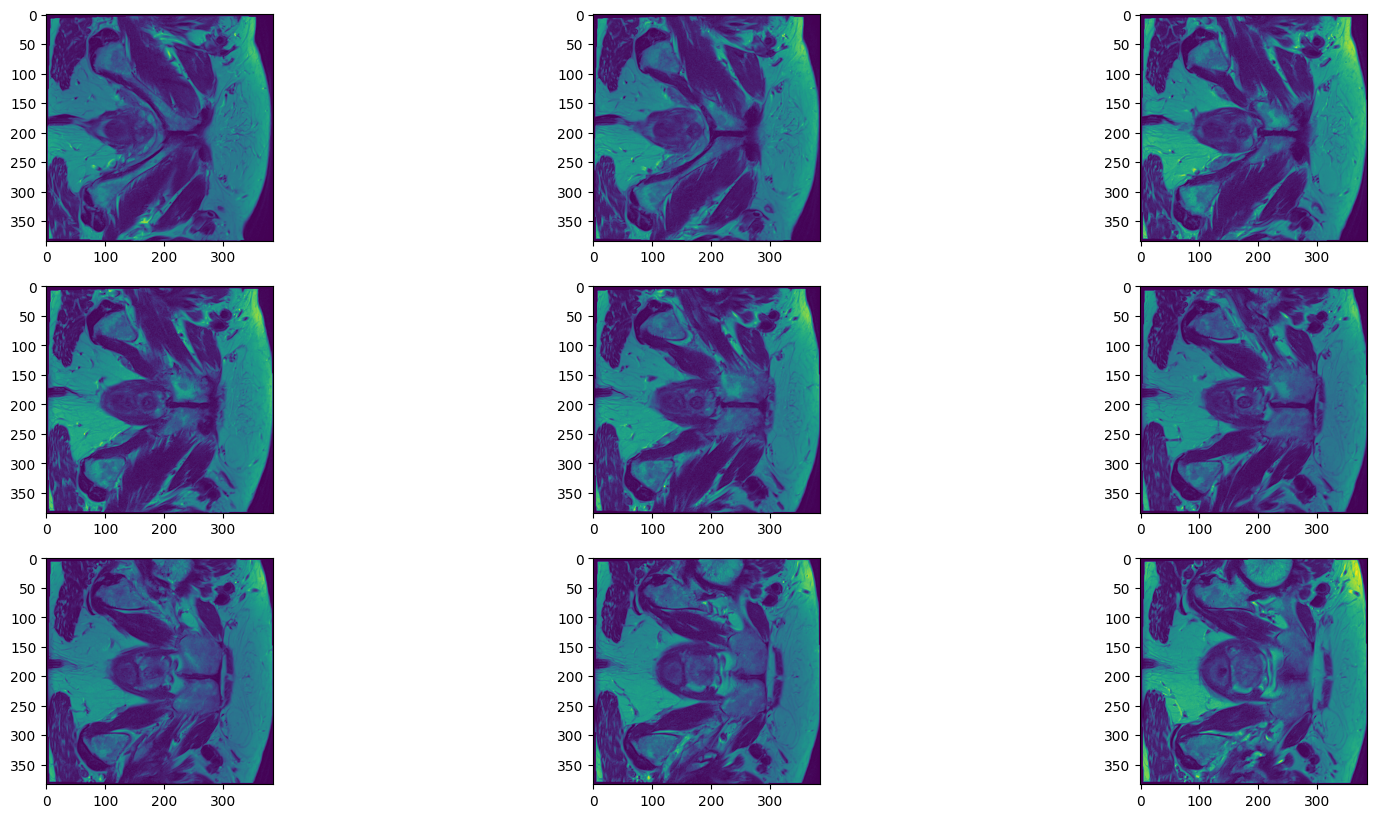

In [12]:
fig, axis = plt.subplots(3, 3, figsize=(20, 10))

slice_counter = 0
for i in range(3):
    for j in range(3):
        axis[i][j].imshow(tr1_fdata[:,:,slice_counter])
        slice_counter+=1

### Explore masks

In [13]:
mask1 = nb.load('Dataset002_Prostate/lesions/Masks/T2/ProstateX-0001-Finding1-t2_tse_tra_ROI.nii.gz')
print(mask1)


<class 'nibabel.nifti1.Nifti1Image'>
data shape (384, 384, 19)
affine:
[[-5.00000000e-01  1.02242048e-10 -3.37603235e-11  1.18955307e+02]
 [ 1.02242048e-10  4.96980477e-01 -3.29202947e-01 -1.24503738e+02]
 [ 5.62672059e-12  5.48671579e-02  2.98188286e+00 -5.43799973e+01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
metadata:
<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : np.bytes_(b'')
db_name         : np.bytes_(b'')
extents         : 0
session_error   : 0
regular         : np.bytes_(b'r')
dim_info        : 0
dim             : [  3 384 384  19   1   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : uint16
bitpix          : 16
slice_start     : 0
pixdim          : [-1.   0.5  0.5  3.   0.   0.   0.   0. ]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 2
cal_max    

In [14]:
mask1_fdata = mask1.get_fdata()
print(mask1_fdata.dtype, mask1_fdata.shape)

float64 (384, 384, 19)


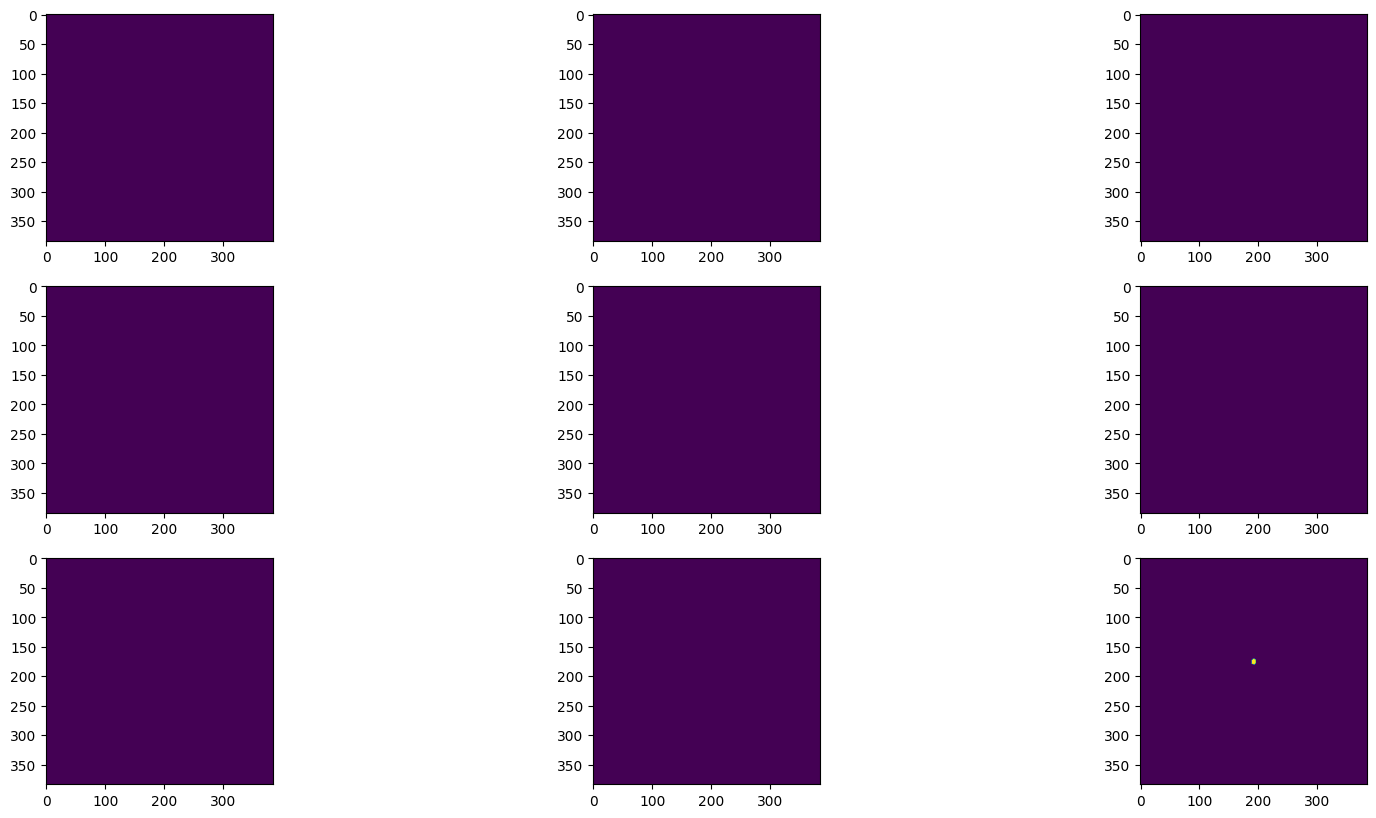

In [15]:
fig, axis = plt.subplots(3, 3, figsize=(20, 10))

slice_counter = 0
for i in range(3):
    for j in range(3):
        axis[i][j].imshow(mask1_fdata[:,:,slice_counter])
        slice_counter+=1

### Apply masks to images, split data

In [58]:
image_dir = 'Dataset002_Prostate/lesions/Images/T2'
image_files = sorted([f for f in os.listdir(image_dir) if f.endswith('.nii') or f.endswith('.nii.gz')])

mask_dir = 'Dataset002_Prostate/lesions/Masks/T2'
mask_files = sorted([f for f in os.listdir(mask_dir) if f.endswith('.nii') or f.endswith('.nii.gz')])

In [61]:
if len(image_files) == len(mask_files):
    print('Image counts match')

Image counts match


In [62]:
def load_nifti(file_path):
    img = nb.load(file_path)
    return img.get_fdata()

In [63]:
images = [load_nifti(os.path.join(image_dir, img_file)) for img_file in image_files]
masks = [load_nifti(os.path.join(mask_dir, mask_file)) for mask_file in mask_files]

In [87]:
target_shape = (128, 128, 128)

def resize_volume(volume, target_shape):
    return resize(volume, target_shape, mode='constant', preserve_range=True)

resized_images = [resize_volume(img, target_shape) for img in images]
resized_masks = [resize_volume(mask, target_shape) for mask in masks]

In [88]:
masked_images = [img * mask for img, mask in zip(resized_images, resized_masks)]

In [128]:
masked_images_normalized = [img / np.max(img) if np.max(img) != 0 else img for img in masked_images]
masked_images_normalized = np.array(masked_images_normalized)

In [90]:
resized_masks = np.array(resized_masks)

In [110]:
labels_file = 'labels.csv'
labels_df = pd.read_csv(labels_file)
labels_df['image_path'] = labels_df['ID'].apply(lambda x: os.path.join(image_dir, f'{x}.nii') if f'{x}.nii' in image_files else os.path.join(image_dir, f'{x}.nii.gz'))

In [111]:
labels_df.drop('Gleason Grade Group', axis=1)

,Unnamed: 0,ID,Clinically Significant,image_path
0,0,ProstateX-0000_Finding1,True,Dataset002_Prostate/lesions/Images/T2\Prostate...
1,1,ProstateX-0001_Finding1,False,Dataset002_Prostate/lesions/Images/T2\Prostate...
2,2,ProstateX-0002_Finding1,True,Dataset002_Prostate/lesions/Images/T2\Prostate...
3,4,ProstateX-0003_Finding1,False,Dataset002_Prostate/lesions/Images/T2\Prostate...
4,6,ProstateX-0004_Finding1,False,Dataset002_Prostate/lesions/Images/T2\Prostate...
...,...,...,...,...
196,292,ProstateX-0200_Finding1,True,Dataset002_Prostate/lesions/Images/T2\Prostate...
197,294,ProstateX-0201_Finding1,True,Dataset002_Prostate/lesions/Images/T2\Prostate...
198,295,ProstateX-0202_Finding1,True,Dataset002_Prostate/lesions/Images/T2\Prostate...
199,297,ProstateX-0203_Finding1,True,Dataset002_Prostate/lesions/Images/T2\Prostate...


In [126]:
labels = labels_df['Clinically Significant'].values

labels = np.array([1 if label == 'True' else 0 for label in labels])

In [129]:
X_train, X_test, y_train, y_test = train_test_split(masked_images_normalized, labels, test_size=0.2, random_state=42)

In [130]:
X_train_tensor = torch.Tensor(X_train)
X_test_tensor = torch.Tensor(X_test)
y_train_tensor = torch.LongTensor(y_train)
y_test_tensor = torch.LongTensor(y_test)

In [131]:
# Create DataLoader for training and testing sets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

## Build the classifier

In [134]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv3d(1, 32, kernel_size=3)
        self.conv2 = nn.Conv3d(32, 64, kernel_size=3)
        self.pool = nn.MaxPool3d(2)
        self.fc1 = nn.Linear(64 * 30 * 30 * 30, 128)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = self.pool(nn.functional.relu(self.conv2(x)))
        x = x.view(-1, 64 * 30 * 30 * 30)
        x = nn.functional.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        return x

In [135]:
model = SimpleCNN()
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
for epoch in range(5):
    model.train()
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch + 1}, Loss: {running_loss / len(train_loader)}")

RuntimeError: Given groups=1, weight of size [32, 1, 3, 3, 3], expected input[1, 32, 128, 128, 128] to have 1 channels, but got 32 channels instead